In [1]:
# import community  #conda install conda-forge::python-louvain
import matplotlib.pyplot as plt
import networkx as nx  #conda install anaconda::networkx
import numpy as np
import pandas as pd

from collections import Counter, defaultdict
from glycowork.glycan_data.loader import glycan_binding, lectin_specificity
#pip install git+https://github.com/BojarLab/glycowork.git
from itertools import combinations
from typing import Any, Dict, List, Set, Tuple, Optional

In [2]:
# Haven't found documentation on what these columns mean. Let's omit them for now.
www_columns = [col for col in glycan_binding.columns if col.startswith("www")]
glycan_lectin_dataframe = glycan_binding.drop(columns=www_columns)

In [3]:
def create_glycan_binding_network(df, directed=None):

    B = nx.DiGraph() if directed else nx.Graph()

    glycan_nodes = set(df.columns[1:-2])
    protein_nodes = set(df['protein'])

    B.add_nodes_from(glycan_nodes, bipartite=0, type='glycan')
    B.add_nodes_from(protein_nodes, bipartite=1, type='protein')

    for idx, row in df.iterrows():
        protein = row['protein']
        for glycan in glycan_nodes:
            if pd.notna(row[glycan]) and (float(row[glycan]) >= 0):  # Discard negative values, as most authors can't explain what they mean in terms of binding
                weight = float(row[glycan])
                if directed == 'glycan_to_protein':
                    B.add_edge(glycan, protein, weight=weight, abs_weight=abs(weight))
                elif directed == 'protein_to_glycan':
                    B.add_edge(protein, glycan, weight=weight, abs_weight=abs(weight))
                else:
                    B.add_edge(protein, glycan, weight=weight, abs_weight=abs(weight))

    return B

def get_bipartite_sets(B):
    return nx.bipartite.sets(B)

In [4]:
B = create_glycan_binding_network(glycan_lectin_dataframe)  # Start by analyzing the full network (not directed)

In [5]:
connected_components = list(nx.connected_components(B))  # Too many errors despite error handling, default to main connected component
connected_components.sort(key=len, reverse=True)
for component in connected_components:
    print(len(component))

3175
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

In [6]:
B0 = B.subgraph(max(connected_components, key=len))  

In [7]:
top_nodes = {n for n, d in B0.nodes(data=True) if d['type']=='glycan'}
bottom_nodes = {n for n, d in B0.nodes(data=True) if d['type']=='protein'}

In [9]:
def calculate_degree_assortativity(G: nx.Graph, top_nodes_: Set):
    
    edges = list(G.edges())

    if not edges:
        return 0.0

    xy = []

    for edge in edges:
        node1, node2 = edge
        if node1 not in top_nodes_:
            node1, node2 = node2, node1
        if node1 in top_nodes_:  # Safety check
            xy.append((G.degree(node1), G.degree(node2)))

    if not xy:
        return 0.0

    x = [pair[0] for pair in xy]
    y = [pair[1] for pair in xy]

    try:
        return np.corrcoef(x, y)[0,1]
    except:
        return 0.0

In [10]:
def calculate_redundancy_metrics(G: nx.Graph, top_nodes_: Set, bottom_nodes_: Set) -> Dict[str, float]:

    metrics_ = {}

    top_redundancy = []
    for node in top_nodes_:
        neighbors = list(G.neighbors(node))
        if len(neighbors) >= 2:
            redundant_pairs = 0
            total_pairs = 0
            for i, n1 in enumerate(neighbors):
                for n2 in neighbors[i+1:]:
                    total_pairs += 1
                    common = set(G.neighbors(n1)) & set(G.neighbors(n2))
                    common.discard(node)
                    if common:
                        redundant_pairs += 1
            if total_pairs > 0:
                top_redundancy.append(redundant_pairs / total_pairs)

    bottom_redundancy = []
    for node in bottom_nodes_:
        neighbors = list(G.neighbors(node))
        if len(neighbors) >= 2:
            redundant_pairs = 0
            total_pairs = 0
            for i, n1 in enumerate(neighbors):
                for n2 in neighbors[i+1:]:
                    total_pairs += 1
                    common = set(G.neighbors(n1)) & set(G.neighbors(n2))
                    common.discard(node)
                    if common:
                        redundant_pairs += 1
            if total_pairs > 0:
                bottom_redundancy.append(redundant_pairs / total_pairs)

    metrics_['top_redundancy'] = np.mean(top_redundancy) if top_redundancy else 0
    metrics_['bottom_redundancy'] = np.mean(bottom_redundancy) if bottom_redundancy else 0

    return metrics_

In [11]:
def calculate_cross_partition_distances(G: nx.Graph, top_nodes: Set,
                                        bottom_nodes: Set) -> Dict[str, float]:

    distances = []

    for u in top_nodes:
        for v in bottom_nodes:
            try:
                dist = nx.shortest_path_length(G, u, v)
                distances.append(dist)
            except nx.NetworkXNoPath:
                continue

    if not distances:
        return {'average': float('inf'), 'max': float('inf'), 'min': float('inf')}

    return {
        'average': np.mean(distances),
        'max': max(distances),
        'min': min(distances)
    }

In [12]:
def calculate_bipartite_degree_centralization(G: nx.Graph, nodes: Set) -> float:

    n = len(nodes)
    if n < 2:
        return 0

    degrees = [G.degree(v) for v in nodes]
    max_degree = max(degrees)

    sum_diff = sum(max_degree - d for d in degrees)

    other_partition_size = G.number_of_nodes() - n
    max_possible = n * (other_partition_size - 1)

    if max_possible == 0:
        return 0

    return sum_diff / max_possible

In [13]:
def calculate_specialization_metrics(G: nx.Graph, top_nodes: Set,
                                     bottom_nodes: Set) -> Dict[str, float]:

    metrics = {}

    top_degrees = [G.degree(n) for n in top_nodes]
    bottom_degrees = [G.degree(n) for n in bottom_nodes]

    metrics['top_degree_heterogeneity'] = np.std(top_degrees) / np.mean(top_degrees) if np.mean(top_degrees) > 0 else 0
    metrics['bottom_degree_heterogeneity'] = np.std(bottom_degrees) / np.mean(bottom_degrees) if np.mean(bottom_degrees) > 0 else 0

    top_neighbor_degrees = []
    bottom_neighbor_degrees = []

    for node in top_nodes:
        neighbors = list(G.neighbors(node))
        if neighbors:
            avg_neighbor_degree = np.mean([G.degree(n) for n in neighbors])
            top_neighbor_degrees.append((G.degree(node), avg_neighbor_degree))

    for node in bottom_nodes:
        neighbors = list(G.neighbors(node))
        if neighbors:
            avg_neighbor_degree = np.mean([G.degree(n) for n in neighbors])
            bottom_neighbor_degrees.append((G.degree(node), avg_neighbor_degree))

    if top_neighbor_degrees:
        metrics['top_neighbor_degree_correlation'] = np.corrcoef(
            [x[0] for x in top_neighbor_degrees],
            [x[1] for x in top_neighbor_degrees]
        )[0,1]
    else:
        metrics['top_neighbor_degree_correlation'] = None

    if bottom_neighbor_degrees:
        metrics['bottom_neighbor_degree_correlation'] = np.corrcoef(
            [x[0] for x in bottom_neighbor_degrees],
            [x[1] for x in bottom_neighbor_degrees]
        )[0,1]
    else:
        metrics['bottom_neighbor_degree_correlation'] = None

    return metrics

In [14]:
def calculate_projection_metrics(G: nx.Graph, top_nodes: Set,
                                 bottom_nodes: Set) -> Dict[str, float]:

    metrics = {}

    try:

        top_proj = nx.bipartite.projected_graph(G, top_nodes)
        bottom_proj = nx.bipartite.projected_graph(G, bottom_nodes)

        metrics['projected_top_density'] = nx.density(top_proj)
        metrics['projected_bottom_density'] = nx.density(bottom_proj)

        metrics['projected_top_avg_degree'] = np.mean([d for _, d in top_proj.degree()])
        metrics['projected_bottom_avg_degree'] = np.mean([d for _, d in bottom_proj.degree()])

        metrics['projected_top_components'] = nx.number_connected_components(top_proj)
        metrics['projected_bottom_components'] = nx.number_connected_components(bottom_proj)
    except:
        metrics['projected_top_density'] = None
        metrics['projected_bottom_density'] = None
        metrics['projected_top_avg_degree'] = None
        metrics['projected_bottom_avg_degree'] = None
        metrics['projected_top_components'] = None
        metrics['projected_bottom_components'] = None

    return metrics

In [15]:
def calculate_bipartite_global_statistics(G: nx.Graph) -> Dict[str, Any]:

    if not nx.is_bipartite(G):
        raise ValueError("Input graph must be bipartite")

    stats = {}

    try:
        top_nodes, bottom_nodes = nx.bipartite.sets(G)
    except:

        color = nx.bipartite.color(G)
        top_nodes = {n for n, c in color.items() if c == 0}
        bottom_nodes = {n for n, c in color.items() if c == 1}

    stats['num_nodes'] = G.number_of_nodes()
    stats['num_edges'] = G.number_of_edges()
    stats['num_top_nodes'] = len(top_nodes)
    stats['num_bottom_nodes'] = len(bottom_nodes)

    stats['bipartite_density'] = G.number_of_edges() / (len(top_nodes) * len(bottom_nodes))

    top_degrees = [G.degree(n) for n in top_nodes]
    bottom_degrees = [G.degree(n) for n in bottom_nodes]

    stats['avg_top_degree'] = np.mean(top_degrees)
    stats['min_top_degree'] = min(top_degrees)
    stats['max_top_degree'] = max(top_degrees)
    stats['std_top_degree'] = np.std(top_degrees)

    stats['avg_bottom_degree'] = np.mean(bottom_degrees)
    stats['min_bottom_degree'] = min(bottom_degrees)
    stats['max_bottom_degree'] = max(bottom_degrees)
    stats['std_bottom_degree'] = np.std(bottom_degrees)

    stats['degree_assortativity'] = calculate_degree_assortativity(G, top_nodes)

    if nx.is_connected(G):
        stats['diameter'] = nx.diameter(G)
        stats['radius'] = nx.radius(G)
        stats['avg_shortest_path'] = nx.average_shortest_path_length(G)

        cross_distances = calculate_cross_partition_distances(G, top_nodes, bottom_nodes)
        stats['avg_cross_partition_distance'] = cross_distances['average']
        stats['max_cross_partition_distance'] = cross_distances['max']
        stats['min_cross_partition_distance'] = cross_distances['min']
    else:
        stats['diameter'] = float('inf')
        stats['radius'] = float('inf')
        stats['avg_shortest_path'] = float('inf')
        stats['avg_cross_partition_distance'] = float('inf')
        stats['max_cross_partition_distance'] = float('inf')
        stats['min_cross_partition_distance'] = float('inf')

    stats['num_components'] = nx.number_connected_components(G)

    stats['degree_centralization_top'] = calculate_bipartite_degree_centralization(G, top_nodes)
    stats['degree_centralization_bottom'] = calculate_bipartite_degree_centralization(G, bottom_nodes)

    try:
        stats['edge_connectivity'] = nx.edge_connectivity(G)
        stats['node_connectivity'] = nx.node_connectivity(G)
    except:
        stats['edge_connectivity'] = 0
        stats['node_connectivity'] = 0

    projected_stats = calculate_projection_metrics(G, top_nodes, bottom_nodes)
    stats.update(projected_stats)

    redundancy_stats = calculate_redundancy_metrics(G, top_nodes, bottom_nodes)
    stats.update(redundancy_stats)

    spec_metrics = calculate_specialization_metrics(G, top_nodes, bottom_nodes)
    stats.update(spec_metrics)

    return stats

In [19]:
stats = calculate_bipartite_global_statistics(B0)

print("\nBipartite Network Statistics:")
print("-" * 50)
for metric, value in stats.items():
    if isinstance(value, float):
        print(f"{metric:30} : {value:.4f}")
    else:
        print(f"{metric:30} : {value}")

KeyboardInterrupt: 

In [17]:
def plot_network_statistics(G: nx.Graph, stats: Dict[str, Any], figsize=(20, 15)) -> None:
    """
    Create a comprehensive visualization of network statistics for a bipartite network.
    
    Parameters:
    -----------
    G : networkx.Graph
        The bipartite network to analyze
    stats : Dict[str, Any]
        Dictionary of pre-calculated network statistics
    figsize : tuple
        Figure size for the entire plot grid
    """
    # Set up the plotting grid
    fig = plt.figure(figsize=figsize)
    gs = plt.GridSpec(3, 1, figure=fig)
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    # Get node sets
    top_nodes = {n for n, d in G.nodes(data=True) if d['type'] == 'glycan'}
    bottom_nodes = {n for n, d in G.nodes(data=True) if d['type'] == 'protein'}

    # 1. Degree Distributions (top left)
    ax1 = fig.add_subplot(gs[0, 0])
    top_degrees = [G.degree(n) for n in top_nodes]
    bottom_degrees = [G.degree(n) for n in bottom_nodes]


    ax1.hist(top_degrees, bins=50, alpha=0.5, density=True, label='Glycans', color='blue')
    ax1.hist(bottom_degrees, bins=50, alpha=0.5, density=True, label='Proteins', color='red')
    ax1.set_xlabel('Degree')
    ax1.set_ylabel('Density')
    ax1.set_title('Degree Distributions')
    ax1.legend()
    ax1.set_yscale('log')
    ax1.set_xscale('log')


    ax2 = fig.add_subplot(gs[0, 1])
    edge_degrees = [(G.degree(u), G.degree(v)) for u, v in G.edges()]
    x_deg, y_deg = zip(*edge_degrees)


    h = ax2.hist2d(x_deg, y_deg, bins=50, cmap='viridis', norm=plt.matplotlib.colors.LogNorm())
    plt.colorbar(h[3], ax=ax2)
    ax2.set_xlabel('Glycan Degree')
    ax2.set_ylabel('Protein Degree')
    ax2.set_title(f'Degree Correlations\nAssortativity: {stats["degree_assortativity"]:.3f}')
    ax2.set_xscale('log')
    ax2.set_yscale('log')

    ax3 = fig.add_subplot(gs[2, 0])
    densities = {
        'Bipartite': stats['bipartite_density'],
        'Glycan Proj.': stats['projected_top_density'],
        'Protein Proj.': stats['projected_bottom_density']
    }
    ax3.bar(densities.keys(), densities.values(), color=['purple', 'blue', 'red'], alpha=0.7)
    ax3.set_ylabel('Density')
    ax3.set_title('Network Densities')
    
    plt.suptitle('Bipartite Network Analysis', fontsize=16, y=0.95)
    plt.show()

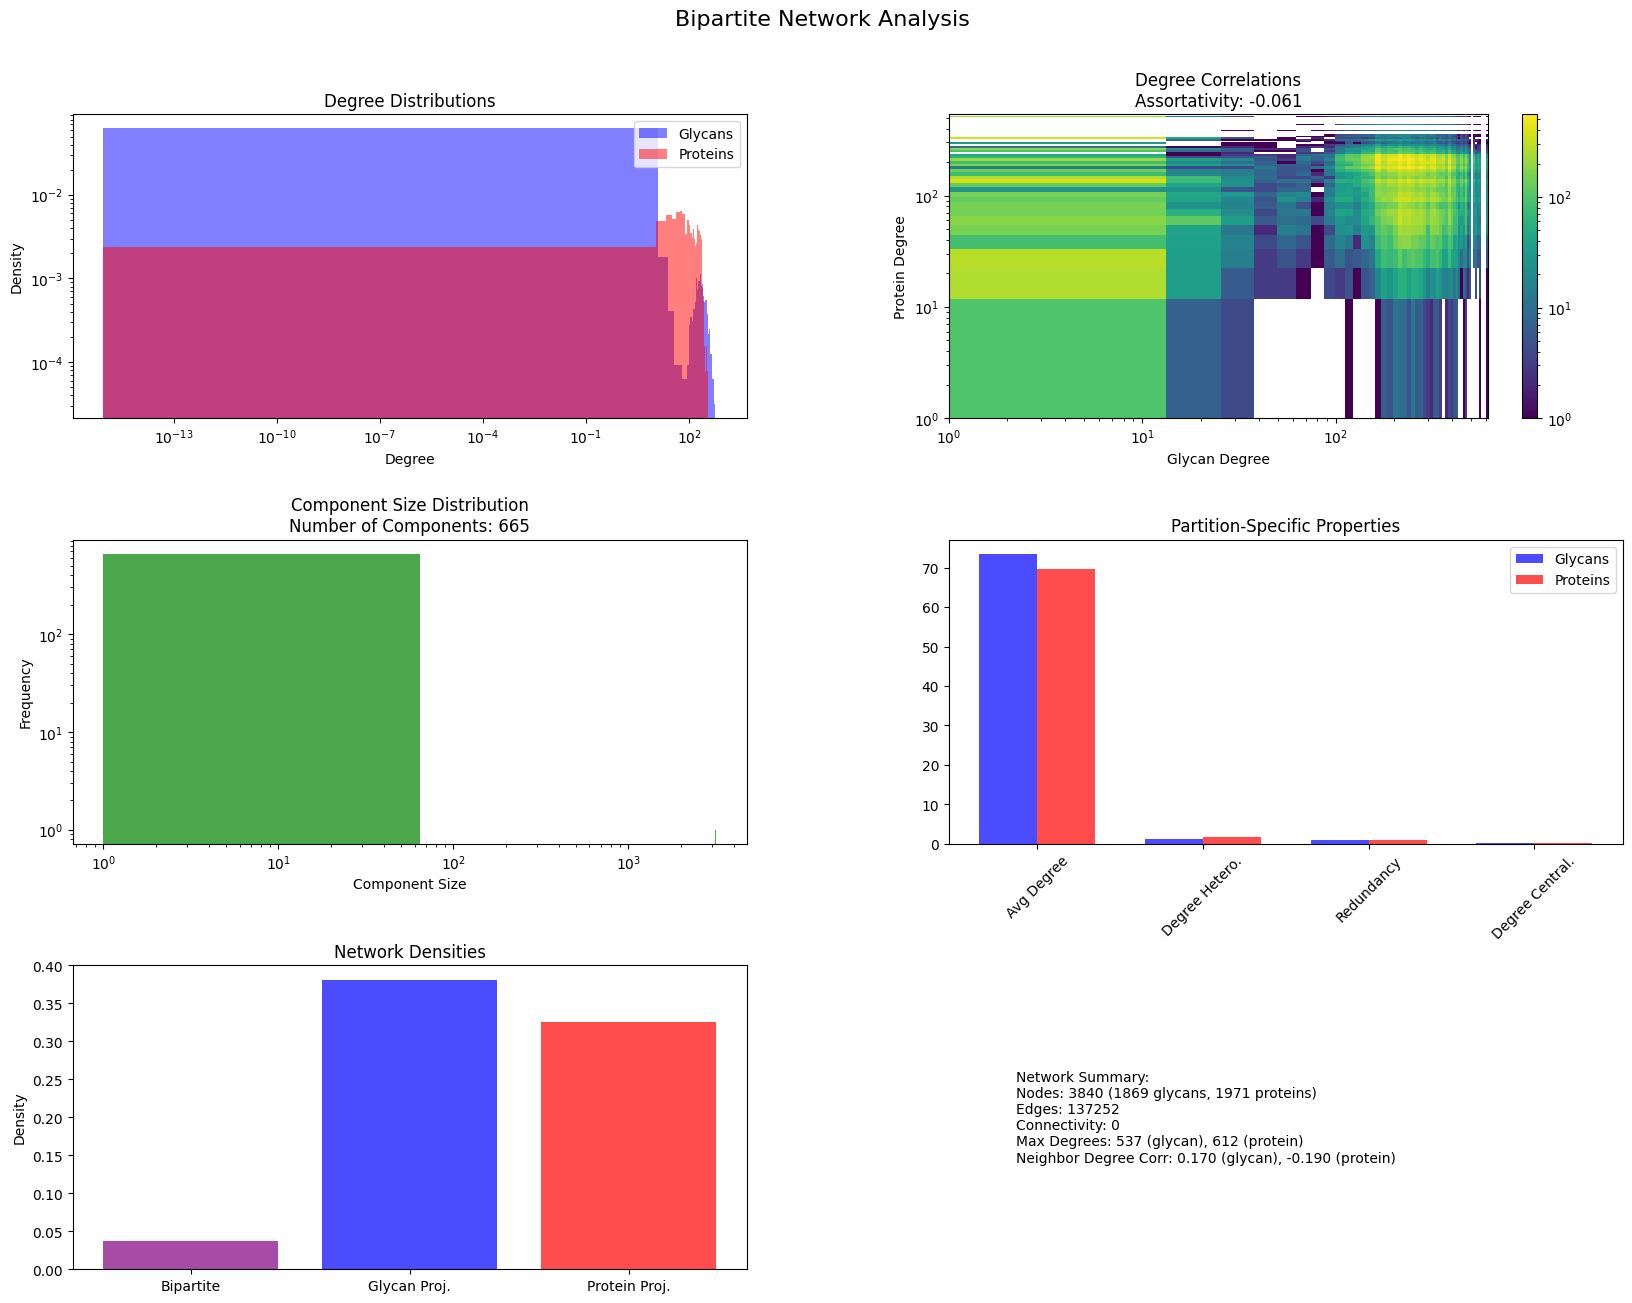

In [18]:
plot_network_statistics(B0, stats)